# Insight Data Science Seattle Interview Demo

# Project: predict if a new user of Airbnb will make a booking

## Outline:

1. Pose a question: Is a new user going to make a booking on Airbnb?
2. Prepare a relevant data set
3. Select metrics to measure model performance
4. Exploratory data analysis: Visualization/ Preprocessing/ Feature extraction
5. Build a predictive model

### 1. Define goal

Motivated by the Kaggle competition to predict the destination country of a new user, I adapt the data and the question to fit into a demo that's managable in 5 - 10 min and could be done over the weekend. The multiclass classification problem is transformed into a binary classification problem. About half of users in the training data doesn't make a booking.

Build a model to predict if a new user will make a booking on Airbnb. This will be an interesting question to ask because it could help Airbnb decide how to do marketing, advertisement.

### 2. Prepare data set

Data for this project are downloaded from the Kaggle competition website:
https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data

Out of the features we are given in the full data set, I chose 8 features that I think are most relevant to analyze. They are:
- `age`
- `gender`
- `date_account_created` and `timestamp_first_active`. These are the time stamp of a user's first activity on the website and the date on which users created their accounts. These two could be different because a user might browse the website before she/he decide to register as a user.
- `signup_app`. These are applications through which the users signed up.
- `affiliation_channel`. This is the kind of paid marketing that a user is brought by. For example, SEM means search engine marketing.

The target label in this problem is the `Booking` column which I create from the raw data by marking True/False based on if `NDF` (no destination found) is the value in the country destination column.

Users dataset contains information of users that created their account between July 1, 2012 and July 1, 2014. This covers two years which could capture seasonality variations. Also, there's plenty of time between those date to Dec 5, 2015 when the dataset is uploaded and this allows ample time for the users to make a booking (even though it's still possible that some of the later registered user that haven't yet make a booking but will do in the future).

We are given demographics of users (train_users.csv, test_users.csv), records of users' web sessions (sessions.csv) as well as some basic information (age_gender_bkts.csv, countries.csv) as input datasets.

In [382]:
import warnings
warnings.filterwarnings('ignore')    # suppress warnings for clean demo

pd.set_option('display.max_rows', None)    #don't hide any rows or columns when display
pd.set_option('display.max_columns', None)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
import datetime

#from sklearn import preprocessing
# import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

from sklearn.model_selection import GridSearchCV

#### Load Datasets

In [410]:
users_data = pd.read_csv("airbnb_short.csv")

In [411]:
num_rows, num_cols = users_data.shape
print("There are {:,} rows and {:,} columns in the train_users data.".format(num_rows, num_cols))

There are 183,537 rows and 8 columns in the train_users data.


In [412]:
users_data.head(3)

,id,date_account_created,timestamp_first_active,gender,age,affiliate_channel,signup_app,Booking
0,oamfblpxdy,2014-01-15,2010-04-17 17:26:59,OTHER,45.0,direct,Moweb,True
1,5p0nmf3r6i,2014-05-23,2010-05-28 14:06:42,FEMALE,39.0,direct,Web,False
2,dlg3a9x97v,2014-04-03,2010-07-12 21:29:24,MALE,47.0,sem-brand,Web,False


In [414]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183537 entries, 0 to 183536
Data columns (total 8 columns):
id                        183537 non-null object
date_account_created      183537 non-null object
timestamp_first_active    183537 non-null object
gender                    183537 non-null object
age                       105383 non-null float64
affiliate_channel         183537 non-null object
signup_app                183537 non-null object
Booking                   183537 non-null bool
dtypes: bool(1), float64(1), object(6)
memory usage: 10.0+ MB


*Findings:*
- *Most of the columns are categorical variable.* 
- *`Age` has a lot of missing values.*

### 3. Select metrics to measure model performance

In this problem, `True` outcomes correspond to users who made a booking; `False` outcomes correspond to users who don't make a bookings.
`Accuracy` is one metric that could measure the model performance. `Precision` and `Recall` (or `Sensitivity`) could also be used to measure the model.

- `Precision` = True Positives / (True Positives + False Positives) = fraction of TP in all predicted True
- `Recall` = True Positives / (True Positives + False Negatives) = fraction of TP in all True True

In this case, we would want to capture as much as possible the potential users who will make a booking (favor high recall). And there's not much penalty in falsely categorize users who don't make a booking as who would (indifferent to false alarm).

We could use a F1 score with beta > 1 to emphasize recall, for example, beta = 2.

### 4. Exploratory Data Analysis

##### Basic summary of  `Booking`

In [415]:
users_data['Booking'].value_counts()/float(users_data.shape[0])

False    0.600609
True     0.399391
Name: Booking, dtype: float64

*Finding: About 60% of the users in the dataset don't have a booking.*

#### Label encode `Booking`

In [416]:
label_encoder = LabelEncoder()
users_data.loc[:, 'Booking'] = label_encoder.fit_transform(users_data['Booking'])
country_code_map=dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [417]:
# mapping between booking and its code
country_code_map

{False: 0, True: 1}

#### Relation between `age` and `Booking`

##### Summary statistics of `age`

In [418]:
users_data.age.describe()

count    105383.000000
mean         47.857510
std         145.259336
min           1.000000
25%          28.000000
50%          33.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

#### Missing and invalid `age`

In [419]:
print("Percentage of missing age value in training data: {:.2f}%".format(sum(users_data.age.isnull())/num_rows * 100.))

Percentage of missing age value in training data: 42.58%


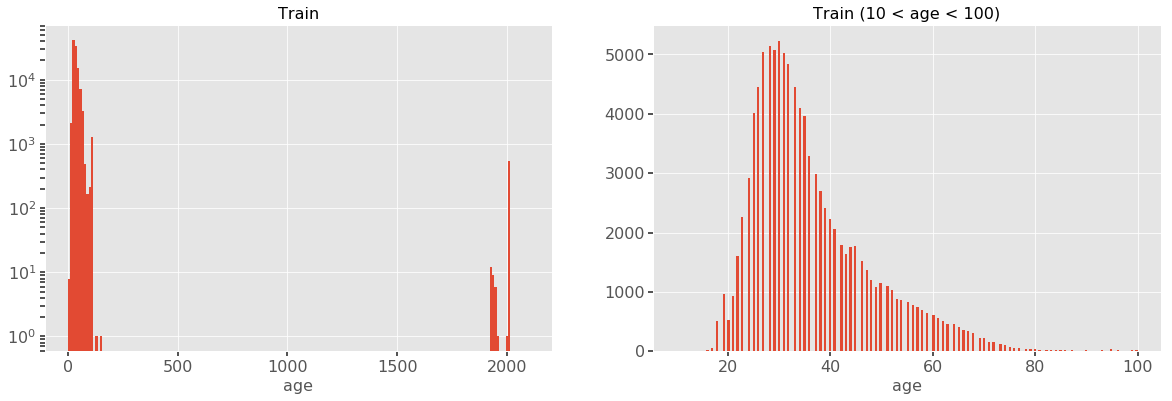

In [420]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6), sharex = False, sharey = False)
ax[0].hist(users_data.age, range = (0, 2100), log = True, bins = 200, normed = False);
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_title('Train', fontsize = 16);
ax[0].set_xlabel('age', fontsize = 16);
ax[1].hist(users_data.age, range = (10, 100), log = False, bins = 200, normed = False);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_title('Train (10 < age < 100)', fontsize = 16);
ax[1].set_xlabel('age', fontsize = 16);

##### `age` & `Booking`

In [421]:
users_data.loc[:,['age', 'Booking']].groupby('Booking').describe()

age                                                      
           count       mean         std  min   25%   50%   75%     max
Booking                                                               
0        48104.0  49.439714  153.133448  1.0  28.0  34.0  44.0  2014.0
1        57279.0  46.528745  138.287963  2.0  28.0  33.0  41.0  2014.0

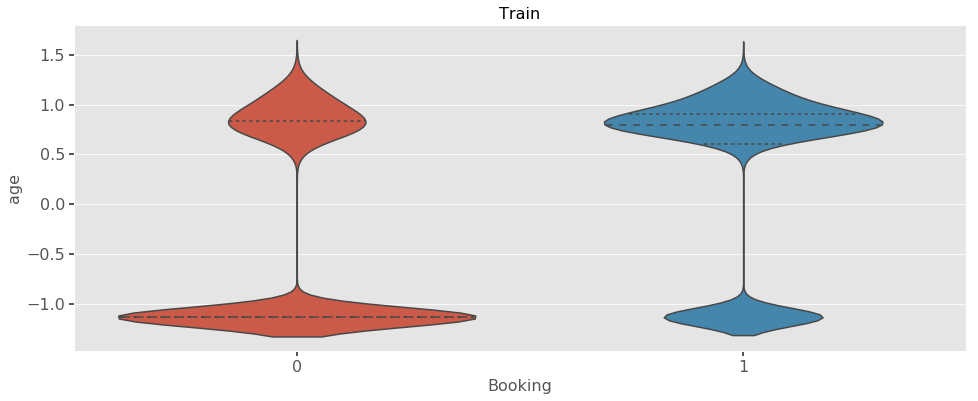

In [448]:
fig, ax = plt.subplots(figsize = (16, 6))
sns.violinplot(x = 'Booking', y = 'age', data = users_data[users_data.age < 100], inner="quartile", split = True, ax = ax);
#ax.set_ylim((0, 120));
ax.set_title('Train', fontsize = 16);
ax.set_xlabel('Booking', fontsize = 16);
ax.set_ylabel('age', fontsize = 16);
ax.tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');

*Finding: Median ages for users that made a booking (`age` = 33) and those made no booking (`age` = 34) are similar. However, distribution of no-booking users has higher mean age (`age` ~ 49) than mean age for users with booking (`age` ~ 47)*

#### Select valid `age` entries

In [423]:
valid_age_index = users_data.age.apply(lambda x: 10 < x < 100)

#### Impute missing/invalid `age` with 10000

In [424]:
users_data.loc[~valid_age_index, 'age'] = 0

#### Log transform `age`

In [425]:
# compute skewness
users_data.age.skew()

0.41051044012983801

#### standardize `age`

In [426]:
users_data.loc[:,'age'] = np.log1p(users_data.age)

In [427]:
standardizer = StandardScaler()
users_data.loc[:, 'age'] = standardizer.fit_transform(users_data.age.values.reshape(-1, 1))

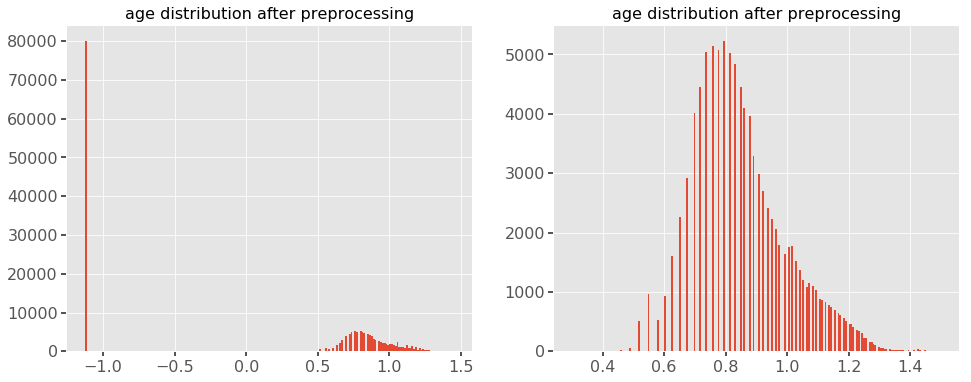

In [428]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6), sharex = False, sharey = False)

ax[0].hist(users_data.age, log = False, bins = 200, normed = False);
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_title('age distribution after preprocessing', fontsize = 16);
#ax[0].set_xlabel('age', fontsize = 16);

ax[1].hist(users_data.age, range = (0.3, 1.5), log = False, bins = 200, normed = False);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_title('age distribution after preprocessing', fontsize = 16);
#ax[1].set_xlabel('age', fontsize = 16);

*Note: In addition to missing values in the datasets, there are illegal values for age. I would take age range larger than 14 and smaller than 100 as the legal range for users on Airbnb. For values between 1920 and 2000, I will treat them as birth year and compute their age in year 2015. I will treat other age same as missing. Then I would convert the age into buckets with 5-year spans.*

#### Categorical features & `Booking`

In [429]:
cat_features = users_data.columns.tolist()
cat_features = [i for i in cat_features if i not in ('Booking', 'id', 'age', 'date_account_created', 'timestamp_first_active')]
print('Total number of categorical features: {}'.format(len(cat_features)))
print('They are:', cat_features)

Total number of categorical features: 3
They are: ['gender', 'affiliate_channel', 'signup_app']


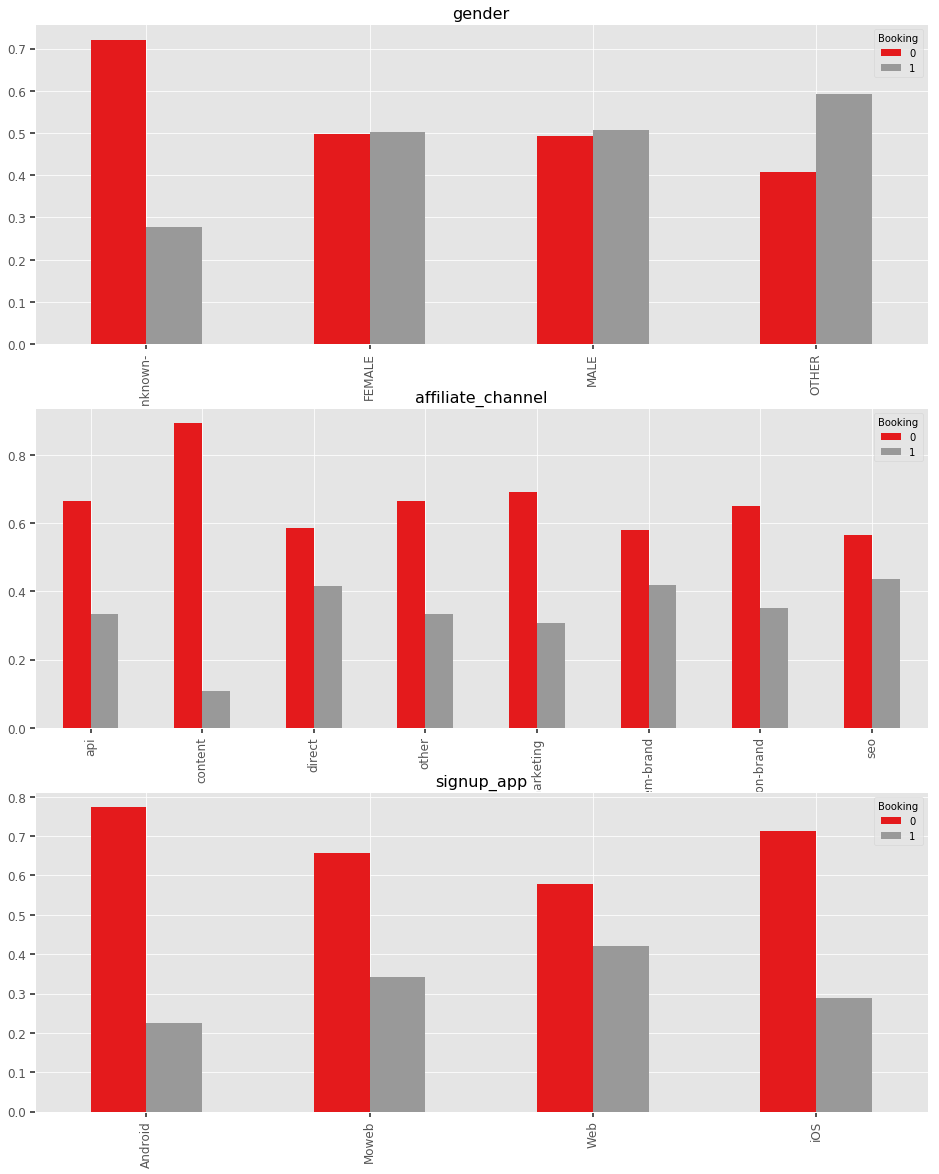

In [431]:
bar_order = users_data['Booking'].value_counts().index.tolist()
fig = plt.figure(figsize = (16, 20));

i = 1
for feat in cat_features:
    cross_tab = pd.crosstab(users_data.Booking, [users_data.loc[:,feat]])
    ax = fig.add_subplot(len(cat_features), 1, i);
    
    ax.tick_params(axis='both',which='both',labelsize=12,\
        length=5,width=2,direction='out');
    tmp = pd.crosstab([users_data.loc[:,feat]], users_data.Booking).apply(lambda x: x/x.sum(), axis=1)
    tmp.plot(kind='bar', stacked=False, ax = ax, legend = True, colormap = 'Set1');
    ax.set_xlabel('');
    ax.set_title(feat, fontsize = 16);
    i += 1

#### Label encode categorical features

In [432]:
feat_code_map = dict()
for feat in cat_features:
    users_data.loc[:, feat] = label_encoder.fit_transform(users_data[feat])
    feat_code_map[feat]=dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

#### One-hot encode categorical features

In [433]:
one_hot_encoder = OneHotEncoder(sparse = True)
users_cat_data = one_hot_encoder.fit_transform(users_data[cat_features])
print (users_cat_data.shape)

(183537, 16)


#### Datetime features & `Booking`

In [434]:
users_data.loc[:,'date_account_created'] = pd.to_datetime(users_data.date_account_created)
users_data.loc[:,'timestamp_first_active'] = pd.to_datetime(users_data.timestamp_first_active)

In [435]:
%%time
users_data['date_first_active'] = users_data.timestamp_first_active.apply(lambda x: pd.to_datetime(x.strftime('%x')))
users_data['account_creation_lag'] = users_data.date_account_created == users_data.date_first_active
users_data.account_creation_lag.value_counts()

True     183402
False       135
Name: account_creation_lag, dtype: int64

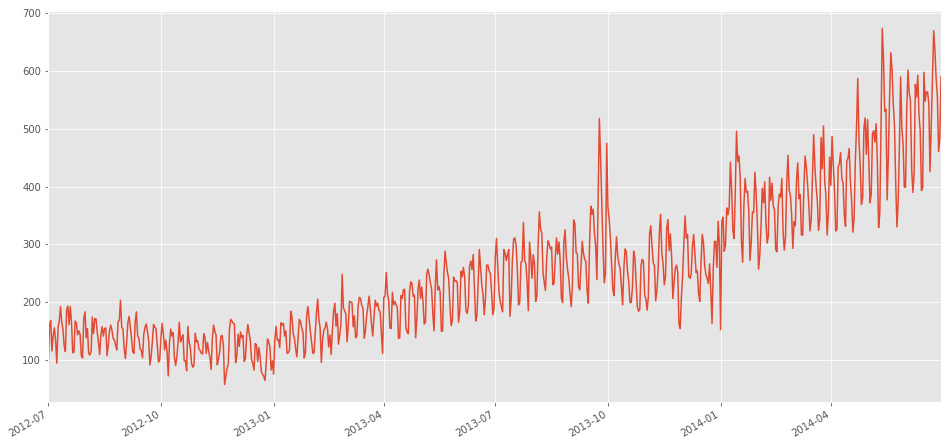

In [436]:
fig, ax = plt.subplots(figsize = (16, 8));
users_data.date_account_created.value_counts().plot();

In [437]:
users_data.drop(['timestamp_first_active', 'date_first_active'], axis = 1, inplace = True)

In [438]:
users_data['year_account_created'] = users_data.date_account_created.apply(lambda x: x.year)
users_data['month_account_created'] = users_data.date_account_created.apply(lambda x: x.month)
users_data['dayinmonth_account_created'] = users_data.date_account_created.apply(lambda x: x.day)
# Monday is 1 and Sunday is 7
users_data['dayinweek_account_created'] = users_data.date_account_created.apply(lambda x: x.isoweekday())

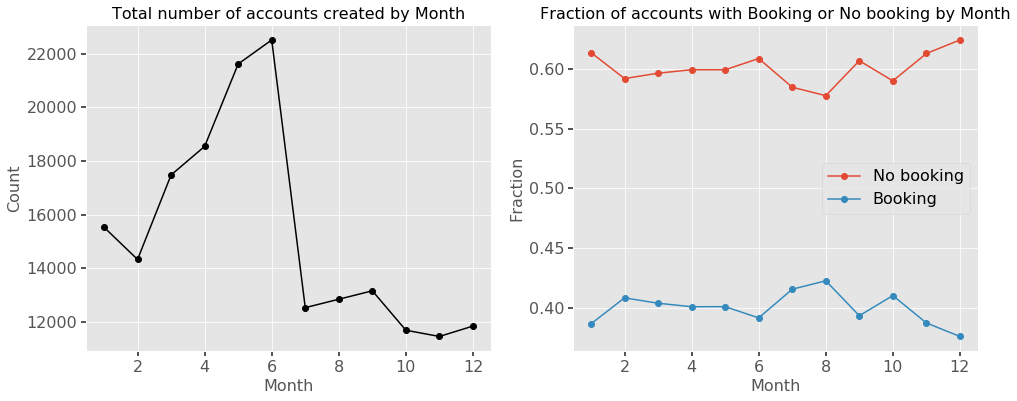

In [439]:
bookings_bymonth = users_data.loc[:, ['Booking', 'month_account_created']].groupby(['month_account_created','Booking']).size().unstack('Booking')
bookings_bymonth['total'] = bookings_bymonth.iloc[:, 0] + bookings_bymonth.iloc[:, 1]
bookings_bymonth['no_booking_fraction'] = bookings_bymonth.iloc[:, 0] / bookings_bymonth['total']
bookings_bymonth['booking_fraction'] = bookings_bymonth.iloc[:, 1] / bookings_bymonth['total']

fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

ax[0].plot(bookings_bymonth.total, 'o-', color = 'black');
ax[0].set_title('Total number of accounts created by Month', fontsize = 16)
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_xlabel('Month', fontsize = 16);
ax[0].set_ylabel('Count', fontsize = 16);

ax[1].plot(bookings_bymonth.no_booking_fraction, 'o-', label = 'No booking');
ax[1].set_title('Fraction of accounts with Booking or No booking by Month', fontsize = 16)
ax[1].plot(bookings_bymonth.booking_fraction, 'o-', label = 'Booking');
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_xlabel('Month', fontsize = 16);
ax[1].set_ylabel('Fraction', fontsize = 16);

*Findings:*
- In terms of total number of accounts created, June is highest, which is almost twice as the lowest month (Nov).
- In terms of the fraction of users who made a booking, the monthly variation is not that large. July and August are slightly higher.

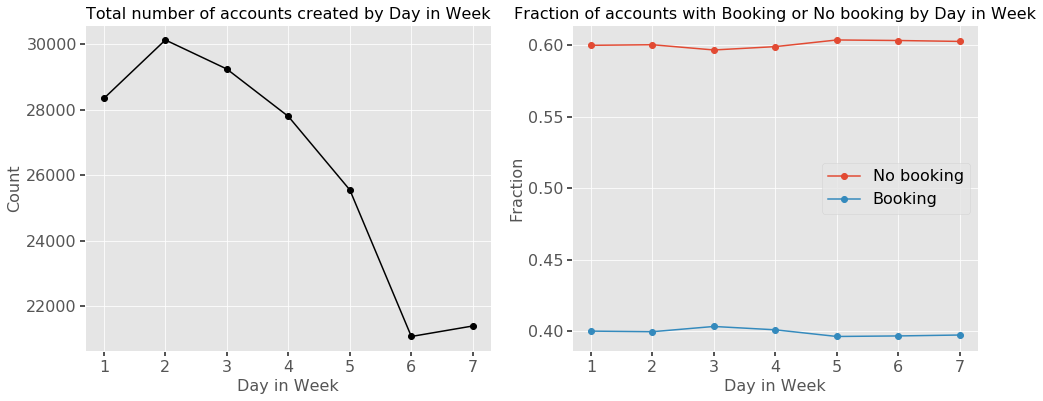

In [440]:
bookings_bydayinweek = users_data.loc[:, ['Booking', 'dayinweek_account_created']].groupby(['dayinweek_account_created','Booking']).size().unstack('Booking')
bookings_bydayinweek['total'] = bookings_bydayinweek.iloc[:, 0] + bookings_bydayinweek.iloc[:, 1]
bookings_bydayinweek['no_booking_fraction'] = bookings_bydayinweek.iloc[:, 0] / bookings_bydayinweek['total']
bookings_bydayinweek['booking_fraction'] = bookings_bydayinweek.iloc[:, 1] / bookings_bydayinweek['total']

fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

ax[0].plot(bookings_bydayinweek.total, 'o-', color = 'black');
ax[0].set_title('Total number of accounts created by Day in Week', fontsize = 16)
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_xlabel('Day in Week', fontsize = 16);
ax[0].set_ylabel('Count', fontsize = 16);

ax[1].plot(bookings_bydayinweek.no_booking_fraction, 'o-', label = 'No booking');
ax[1].set_title('Fraction of accounts with Booking or No booking by Day in Week', fontsize = 16)
ax[1].plot(bookings_bydayinweek.booking_fraction, 'o-', label = 'Booking');
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_xlabel('Day in Week', fontsize = 16);
ax[1].set_ylabel('Fraction', fontsize = 16);

*Findings:*
- Tuesday is the day of week most users sign up for account on Airbnb. Saturday has least number of users create accounts.
- The fraction of users who made a booking is almost constant in terms of the day in week.

In [445]:
users_data.drop('dayinweek_account_created', axis = 1, inplace = True)

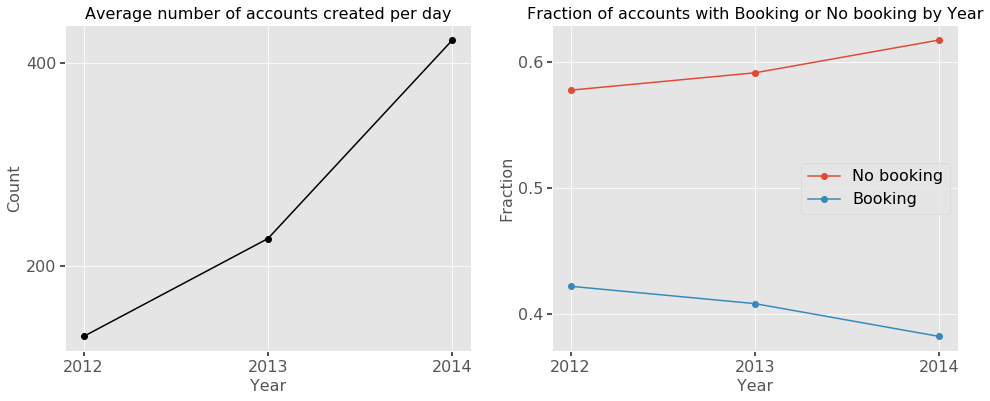

In [446]:
bookings_byyear = users_data.loc[:, ['Booking', 'year_account_created']].groupby(['year_account_created','Booking']).size().unstack('Booking')
bookings_byyear['total'] = bookings_byyear.iloc[:, 0] + bookings_byyear.iloc[:, 1]
bookings_byyear['no_booking_fraction'] = bookings_byyear.iloc[:, 0] / bookings_byyear['total']
bookings_byyear['booking_fraction'] = bookings_byyear.iloc[:, 1] / bookings_byyear['total']
bookings_byyear['number_of_days'] = users_data.loc[:, ['date_account_created', 'year_account_created']]\
                                       .groupby(['year_account_created']).nunique().loc[:,'date_account_created']
bookings_byyear['avg_account_per_day'] = bookings_byyear.total / bookings_byyear.number_of_days


fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

ax[0].plot(bookings_byyear.avg_account_per_day, 'o-', color = 'black');
ax[0].set_title('Average number of accounts created per day', fontsize = 16)
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_xlabel('Year', fontsize = 16);
ax[0].set_ylabel('Count', fontsize = 16);
ax[0].locator_params(nbins = 3);

ax[1].plot(bookings_byyear.no_booking_fraction, 'o-', label = 'No booking');
ax[1].set_title('Fraction of accounts with Booking or No booking by Year', fontsize = 16)
ax[1].plot(bookings_byyear.booking_fraction, 'o-', label = 'Booking');
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_xlabel('Year', fontsize = 16);
ax[1].set_ylabel('Fraction', fontsize = 16);
ax[1].locator_params(nbins = 3);

*Findings:*
- Average number of accounts per day increases from 2012 to 2014.
- However, the fraction of users who made a booking decreases slightly over the same period of time.

In [442]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start = users_data.date_account_created.min(), 
                        end = users_data.date_account_created.max())

users_data['Holiday'] = users_data.date_account_created.isin(holidays)

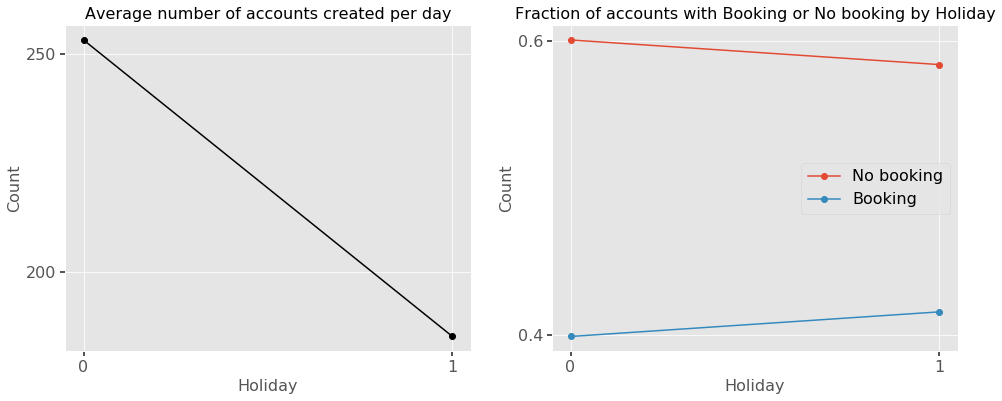

In [443]:
bookings_byholiday = users_data.loc[:, ['Booking', 'Holiday']].groupby(['Holiday','Booking']).size().unstack('Booking')
bookings_byholiday['total'] = bookings_byholiday.iloc[:, 0] + bookings_byholiday.iloc[:, 1]
bookings_byholiday['no_booking_fraction'] = bookings_byholiday.iloc[:, 0] / bookings_byholiday['total']
bookings_byholiday['booking_fraction'] = bookings_byholiday.iloc[:, 1] / bookings_byholiday['total']
bookings_byholiday['number_of_days'] = users_data.loc[:, ['date_account_created', 'Holiday']]\
                                       .groupby(['Holiday']).nunique().loc[:,'date_account_created']
bookings_byholiday['avg_account_per_day'] = bookings_byholiday.total / bookings_byholiday.number_of_days
fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))

ax[0].plot(bookings_byholiday.avg_account_per_day, 'o-', color = 'k');
ax[0].set_title('Average number of accounts created per day', fontsize = 16)
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_xlabel('Holiday', fontsize = 16);
ax[0].set_ylabel('Count', fontsize = 16);
ax[0].locator_params(nbins = 2);

ax[1].plot(bookings_byholiday.no_booking_fraction, 'o-',label = 'No booking');
ax[1].set_title('Fraction of accounts with Booking or No booking by Holiday', fontsize = 16)
ax[1].plot(bookings_byholiday.booking_fraction, 'o-', label = 'Booking');
ax[1].legend(fontsize = 16);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_xlabel('Holiday', fontsize = 16);
ax[1].set_ylabel('Count', fontsize = 16);
ax[1].locator_params(nbins = 2);

*Finding:*
- Less people sign up accounts on US holidays than on other days.
- The fraction of users who made a booking on holiday is slightly higher than on other days.

### 5. Build a predictive model

In [ ]:
from scipy import sparse
full_data_sparse = sparse.hstack((full_data_sparse,full_data[con_cols]), format='csr')
print (full_data_sparse.shape)
train_x = full_data_sparse[:train_size]
test_x = full_data_sparse[train_size:]
train_y = np.log(full_data[:train_size].loss.values + 200)
ID = full_data.id[:train_size].values